## Dependencies

In [71]:
import geopandas as gpd
import joblib
import numpy as np
import odc.geo.xr  # noqa: F401
import pandas as pd
import xarray as xr
import matplotlib as plt
import matplotlib.pyplot as pyplot
import rasterio as rio
from rasterio import plot
from odc.stac import load
from pystac_client import Client
from shapely import geometry
from shapely.geometry import shape, Polygon, MultiPolygon
from shapely import LineString, MultiPoint
from shapely.ops import split
from sklearn.ensemble import RandomForestClassifier
from dask.distributed import Client as dask_client
import warnings
warnings.filterwarnings('ignore')

In [56]:
# Read in data inputs
aoi = gpd.read_file("wavuwavu_extent.geojson")
river_bounds = gpd.read_file("wavuwavu_river.geojson")

In [57]:
lulc_dataarray = xr.DataArray("LULC_2023_wavuwavu_extent")
lulc_dataarray

<xarray.DataArray ()>
array('LULC_2023_wavuwavu_extent', dtype='<U25')

In [58]:
da = rio.open("LULC_2023_wavuwavu_extent.tif")

In [59]:
da

<open DatasetReader name='LULC_2023_wavuwavu_extent.tif' mode='r'>

In [60]:
with rio.open("LULC_2023_wavuwavu_extent.tif") as src:
  # Get data and associated information
  data = src.read(1)  # Assuming single band data, adjust for multi-band
  transform = src.transform  # Get the geotransformation


In [61]:
data

array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 3, 4, ..., 3, 3, 3],
       [3, 3, 3, ..., 4, 3, 3],
       [3, 3, 3, ..., 4, 3, 3]], dtype=uint8)

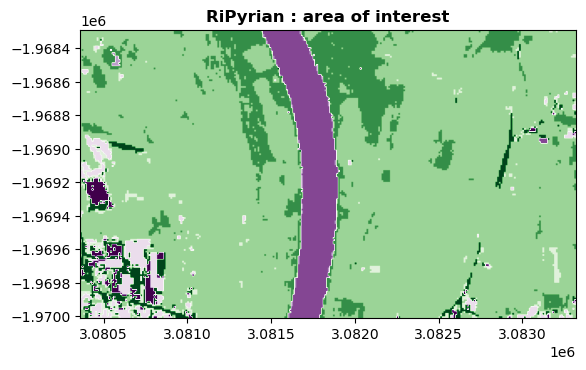

<Axes: title={'center': 'RiPyrian : area of interest'}>

In [62]:
# Plot the data using rasterio.plot
plot.show(data, cmap='PRGn_r', transform=transform, title="RiPyrian : area of interest")
# plt.show(cmap='Reds')  # To display the plot in the notebook

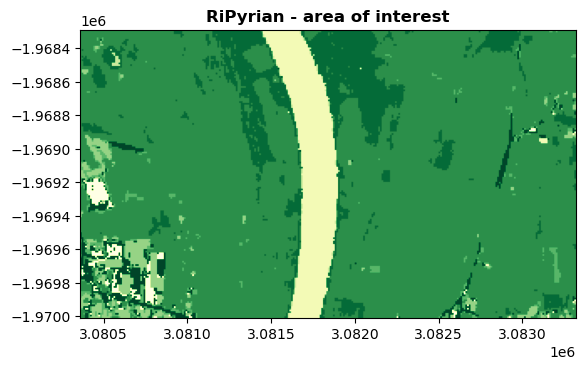

<Axes: title={'center': 'RiPyrian - area of interest'}>

In [63]:
# Plot the data using rasterio.plot
plot.show(data, cmap='YlGn_r', transform=transform, title="RiPyrian - area of interest")
# plt.show(cmap='Reds')  # To display the plot in the notebook

In [64]:
dataarray = xr.DataArray(da)
dataarray

<xarray.DataArray 'LULC_2023_wavuwavu_extent.tif' ()>
array(<open DatasetReader name='LULC_2023_wavuwavu_extent.tif' mode='r'>,
      dtype=object)

In [65]:
river_bounds = river_bounds.fillna(0)
river_bounds

,id,geometry
0,0.0,"MULTIPOLYGON (((177.68288 -17.53067, 177.68287..."


In [66]:
river_bounds.describe

<bound method NDFrame.describe of     id                                           geometry
0  0.0  MULTIPOLYGON (((177.68288 -17.53067, 177.68287...>

In [67]:
river_bounds.type

0    MultiPolygon
dtype: object

<Axes: >

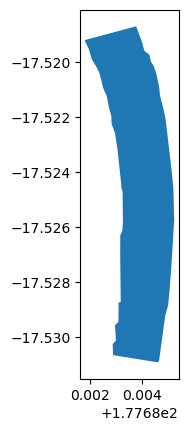

In [68]:
river_bounds.plot()

In [69]:
river_lines = river_bounds.boundary

In [94]:
river_lines = river_lines.to_crs(crs='EPSG:4326')

<Axes: >

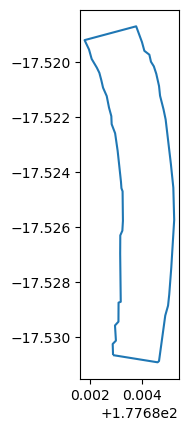

In [95]:
river_lines.plot()

In [187]:
river_lines

0    MULTILINESTRING ((177.68288 -17.53067, 177.682...
dtype: geometry

In [186]:
river_lines.to_file("riverbank_lines.geojson")

In [103]:
def split_multilinestring(multilinestring, segment_length):
  segments = []
  for linestring in multilinestring.geoms:
    # Access coordinates of the current LineString
    coords = linestring.coords

    # ... rest of your code for splitting the LineString using coords
  return segments
  """
  Splits a MultiLineString into segments of a specified length.

  Args:
      multilinestring: A Shapely MultiLineString object.
      segment_length: The desired length of each segment.

  Returns:
      A list of Shapely LineString objects representing the segments.
  """
  segments = []
  for linestring in multilinestring.geometry:
    # Split the individual LineString using a custom function
    segments.extend(split_linestring(linestring, segment_length))
  return segments

def split_linestring(linestring, segment_length):
  """
  Splits a LineString into segments of a specified length.

  Args:
      linestring: A Shapely LineString object.
      segment_length: The desired length of each segment.

  Returns:
      A list of Shapely LineString objects representing the segments.
  """
  # Get the total line length
  line_length = linestring.length

  # Check if segment_length is valid
  if segment_length <= 0:
    raise ValueError("Segment length must be positive.")
  elif segment_length > line_length:
    return [linestring]  # Line is shorter than segment_length, return the line itself

  # Calculate the number of segments
  num_segments = int(line_length // segment_length) + 1

  # Create a list to store the segments
  segments = []

  # Calculate step size (distance between points in segments)
  step_size = line_length / num_segments

  # Iterate and create segments with interpolation
  for i in range(num_segments):
    start_coords = linestring.coords[i]
    end_coords = linestring.interpolate(step_size * (i + 1), normalized=False)
    segment = LineString([start_coords, end_coords])
    segments.append(segment)

  return segments


In [167]:
def split_multilinestring(multilinestring, segment_length):
  segments = []
  for geometry in multilinestring.geometry:
    if geometry.type == "MultiLineString":
      # Code to handle MultiLineString geometry (indentation added)
      pass  # Replace with your actual code for processing MultiLineString
    else:
      # Code to handle non-MultiLineString geometry (indentation added)
      pass  # Replace with your desired behavior for other geometries
  return segments


In [170]:
total_length = river_lines.length
total_length

0    0.028234
dtype: float64

In [169]:
# Example usage
multilinestring = river_lines
segment_length = 8.99774E-05
segments = split_multilinestring(multilinestring, segment_length)

# Process or plot the segments here
print(f"Number of segments: {len(segments)}")

Number of segments: 0


In [173]:
No_segments = total_length/segment_length
No_segments

0    313.792266
dtype: float64

In [181]:
def split_multilinestring(multilinestring, segment_length):
  # Filter for MultiLineString geometries
  multilinestring_filtered = multilinestring[multilinestring.geometry.type == "MultiLineString"]
  segments = []
  # ... rest of your code for iterating through MultiLineStrings in multilinestring_filtered

  return segments



In [182]:
# Example usage
multilinestring = river_lines
segment_length = 8.99774E-05
segments = split_multilinestring(multilinestring_filtered, segment_length)

# Process or plot the segments here
print(f"Number of segments:", {len(segments)})

NameError: name 'multilinestring_filtered' is not defined

In [ ]:
roads = roads['geometry'] # roads contain a single multiline
points = points['geometry'] # points for finding the distance from line segements after segmenting the multiline

plot = roads.iloc[0] # roads.iloc[0] gives a multiline
x = plot.length
x = int(x/0.2)
splitter = MultiPoint([plot.interpolate((i/x), normalized=True) for i in range(1, x)])
#splitter gives the points on multiline at equal distance, but only contains points
plot = gpd.GeoSeries(plot)
splitter = gpd.GeoSeries(splitter)

In [47]:
line = river_lines([(0, 0), (0, 10)])


TypeError: 'GeoSeries' object is not callable

In [48]:
line = LineString([(0, 0), (0, 10)])


In [50]:
segmentize(line, max_segment_length=5)


NameError: name 'segmentize' is not defined

In [ ]:


<LINESTRING (0 0, 0 5, 0 10)>

polygon = Polygon([(0, 0), (10, 0), (10, 10), (0, 10), (0, 0)])

segmentize(polygon, max_segment_length=5)
<POLYGON ((0 0, 5 0, 10 0, 10 5, 10 10, 5 10, 0 10, 0 5, 0 0))>

segmentize(None, max_segment_length=5) is None
True

In [ ]:
segmentize(line, max_segment_length=5)

<LINESTRING (0 0, 0 5, 0 10)>

polygon = Polygon([(0, 0), (10, 0), (10, 10), (0, 10), (0, 0)])

segmentize(polygon, max_segment_length=5)
<POLYGON ((0 0, 5 0, 10 0, 10 5, 10 10, 5 10, 0 10, 0 5, 0 0))>

segmentize(None, max_segment_length=5) is None
True

In [46]:
segmentize(river_lines, 10, **kwargs)

NameError: name 'segmentize' is not defined